In [1]:
"""
r: Zongyi Li and Daniel Zhengyu Huang
"""

import numpy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device is ", (device))

device is  cuda


In [2]:
def Lx2length(L_x, L_p, x1, x2, x3, x4, x5, h):
    # L_x position (positive)
    l0, l1, l2, l3, l4, l5 = -x3, torch.sqrt((x5-x3)**2 + (h/2)**2), torch.sqrt((x5-x2)**2 + (h/2)**2), torch.sqrt((x2-x4)**2 + (h/2)**2), torch.sqrt((x1-x4)**2 + (h/2)**2), L_p+x1
    if L_x < -x3:
        l = L_x
    elif L_x < -x5:
        l = l0 + l1*(L_x + x3)/(x3-x5)
    elif L_x < -x2:
        l = l0 + l1 + l2*(L_x + x5)/(x5-x2)
    elif L_x < -x4:
        l = l0 + l1 + l2 + l3*(L_x + x2)/(x2-x4)
    elif L_x < -x1:
        l = l0 + l1 + l2 + l3 + l4*(L_x + x4)/(x4-x1)
    else:
        l = l0 + l1 + l2 + l3 + l4 + L_x + x1

    return l

def d2xy(d, L_p, x1, x2, x3, x4, x5, h):
    
    p0, p1, p2, p3, p4, p5 = torch.tensor([0.0,0.0]), torch.tensor([x3,0.0]), torch.tensor([x5, h/2]), torch.tensor([x2, h]), torch.tensor([x4,h/2]), torch.tensor([x1,0.0])
    v0, v1, v2, v3, v4, v5 = torch.tensor([x3-0,0.0]), torch.tensor([x5-x3,h/2]), torch.tensor([x2-x5,h/2]), torch.tensor([x4-x2,-h/2]), torch.tensor([x1-x4,-h/2]), torch.tensor([-L_p-x1,0.0])
    l0, l1, l2, l3, l4, l5 = -x3, torch.sqrt((x5-x3)**2 + (h/2)**2), torch.sqrt((x5-x2)**2 + (h/2)**2), torch.sqrt((x2-x4)**2 + (h/2)**2), torch.sqrt((x1-x4)**2 + (h/2)**2), L_p+x1
    
    xx, yy = torch.zeros(d.shape), torch.zeros(d.shape)
    ind = (d < l0)
    xx[ind] = d[ind]*v0[0]/l0 + p0[0]
    yy[ind] = d[ind]*v0[1]/l0 + p0[1]
    
    ind = torch.logical_and(d < l0 + l1, d>=l0)
    xx[ind] = (d[ind]-l0)*v1[0]/l1 + p1[0] 
    yy[ind] = (d[ind]-l0)*v1[1]/l1 + p1[1]
    
    ind = torch.logical_and(d < l0 + l1 + l2, d>=l0 + l1)
    xx[ind] = (d[ind]-l0-l1)*v2[0]/l2 + p2[0]
    yy[ind] = (d[ind]-l0-l1)*v2[1]/l2 + p2[1]
    
    ind = torch.logical_and(d < l0 + l1 + l2 + l3, d>=l0 + l1 + l2)
    xx[ind] = (d[ind]-l0-l1-l2)*v3[0]/l3 + p3[0]
    yy[ind] = (d[ind]-l0-l1-l2)*v3[1]/l3 + p3[1]
    
    ind = torch.logical_and(d < l0 + l1 + l2 + l3 + l4, d>=l0 + l1 + l2 + l3)
    xx[ind] = (d[ind]-l0-l1-l2-l3)*v4[0]/l4 + p4[0]
    yy[ind] = (d[ind]-l0-l1-l2-l3)*v4[1]/l4 + p4[1]
    
    ind = (d>=l0 + l1 + l2 + l3 + l4)
    xx[ind] = (d[ind]-l0-l1-l2-l3-l4)*v5[0]/l5 + p5[0]
    yy[ind] = (d[ind]-l0-l1-l2-l3-l4)*v5[1]/l5 + p5[1]
    
    return xx, yy

def catheter_mesh_1d_total_length(L_x, L_p, x2, x3, x4, x5, h, N_s):
    x1 = -0.5*L_p
    # ncy = 20
    
    n_periods = torch.floor(L_x / L_p)
    L_x_last_period = L_x - n_periods*L_p
    L_p_s = (x1 + L_p) + (0 - x3) + torch.sqrt((x4 - x1)**2 + (h/2)**2) + torch.sqrt((x4 - x2)**2 + (h/2)**2) + torch.sqrt((x2 - x5)**2 + (h/2)**2) + torch.sqrt((x3 - x5)**2 + (h/2)**2)
    L_s = L_p_s*n_periods + Lx2length(L_x_last_period, L_p, x1, x2, x3, x4, x5, h)
    
    # from 0
    d_arr = torch.linspace(0, 1, N_s) * L_s
    
    # TODO do not compute gradient for floor
    period_arr = torch.floor(d_arr / L_p_s).detach()
    d_arr -= period_arr * L_p_s

    
    xx, yy = d2xy(d_arr, L_p, x1, x2, x3, x4, x5, h)

    xx = xx - period_arr*L_p
    
    
    X_Y = torch.zeros((1, N_s, 2), dtype=torch.float).to(device)
    X_Y[0, :, 0], X_Y[0, :, 1] = xx, yy
    return X_Y, xx, yy




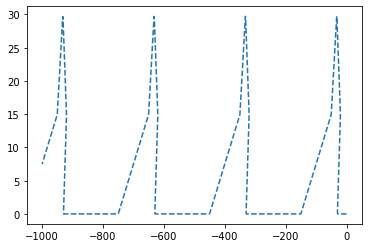

In [3]:
L_x, L_p, x2, x3, x4, x5, h = 1000, 300, -32, -30, -50, -20, 30
x1 = -0.5*L_p
N_s = 1001

L_p, x2, x3, x4, x5, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(x4, dtype=torch.float), torch.tensor(x5, dtype=torch.float), torch.tensor(h, dtype=torch.float)
X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, x4, x5, h, N_s)


X_Y_numpy = X_Y.cpu().numpy()
plt.plot(X_Y_numpy[0, :, 0], X_Y_numpy[0, :, 1], "--")
# plt.xlim([-1000,-600])
# ##################################################
# # Prediction on a special design
# #################################################
# model = torch.load("catheter_plain_period_model_1d500", map_location=device)
# out = torch.clip(model(X_Y).squeeze(), min=0.0).detach().cpu().numpy()
# xx_mask = numpy.linspace(1.0, 0, n_periods*ncx+1) * (-L_p*n_periods)
# print("L_p, x1, x2, x3, h  = ", L_p, x1, x2, x3, h)
# print("loss = ",  -np.dot(out,xx_mask) )
# plt.figure()
# plt.plot(xx_mask, out)


1336001
initialize :  (tensor(100., grad_fn=<AddBackward0>), tensor(-50., grad_fn=<MulBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(-50., grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(25., grad_fn=<AddBackward0>))
0 1.0973117258399725 loss =  240497.25 loss_min =  inf
tensor([ 3.5073, -2.1489,  1.6676,  0.0095,  0.5328,  1.1382],
       grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, x4, x5, h  =  65.52989959716797 -32.764949798583984 -6.8438568115234375 -14.944761276245117 -41.29335021972656 -31.273448944091797 24.97612762451172


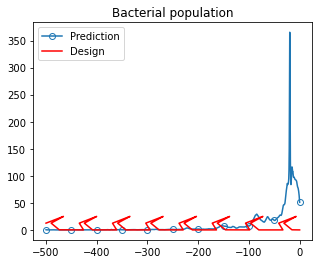

1 0.1922080721706152 loss =  468466.625 loss_min =  240497.25
2 0.1936442330479622 loss =  269674.0625 loss_min =  240497.25
3 0.20863967202603817 loss =  324210.65625 loss_min =  240497.25
4 0.180299811065197 loss =  381203.03125 loss_min =  240497.25
5 0.21137254312634468 loss =  396127.59375 loss_min =  240497.25
6 0.19718366488814354 loss =  425074.0625 loss_min =  240497.25
7 0.18172462470829487 loss =  252529.390625 loss_min =  240497.25
8 0.1943033877760172 loss =  259157.90625 loss_min =  240497.25
9 0.17587397806346416 loss =  261235.390625 loss_min =  240497.25
10 0.19327274709939957 loss =  274907.90625 loss_min =  240497.25
11 0.1932180356234312 loss =  377793.53125 loss_min =  240497.25
12 0.2057446800172329 loss =  684945.5 loss_min =  240497.25
13 0.18966410495340824 loss =  347792.15625 loss_min =  240497.25
14 0.17825392074882984 loss =  329554.78125 loss_min =  240497.25
15 0.19102906249463558 loss =  283768.0625 loss_min =  240497.25
16 0.20050627924501896 loss =  40

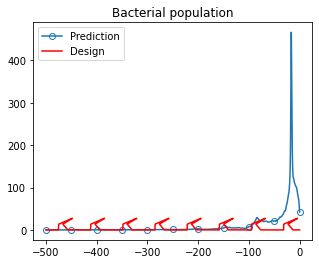

20 0.1824988555163145 loss =  246223.625 loss_min =  233490.75
21 0.19415670074522495 loss =  383427.09375 loss_min =  233490.75
22 0.1944781169295311 loss =  281790.46875 loss_min =  233490.75
23 0.19046425633132458 loss =  350839.125 loss_min =  233490.75
24 0.18099906109273434 loss =  434671.09375 loss_min =  233490.75
25 0.18717867508530617 loss =  270367.125 loss_min =  233490.75
26 0.1830789167433977 loss =  416710.75 loss_min =  233490.75
27 0.1924513280391693 loss =  293005.375 loss_min =  233490.75
28 0.18151422776281834 loss =  203500.125 loss_min =  233490.75
tensor([ 4.1219, -3.5948,  2.4433, -2.1670,  0.7043,  0.9745],
       grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, x4, x5, h  =  63.031307220458984 -31.515653610229492 -1.6849517822265625 -15.195588111877441 -42.17721939086914 -30.62162971496582 28.972475051879883


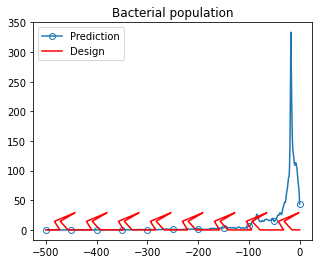

29 0.17905146442353725 loss =  297487.6875 loss_min =  203500.125
30 0.18850019946694374 loss =  287635.4375 loss_min =  203500.125
31 0.16965370252728462 loss =  210047.84375 loss_min =  203500.125
32 0.1777163054794073 loss =  326593.375 loss_min =  203500.125
33 0.1840766929090023 loss =  229114.359375 loss_min =  203500.125
34 0.18051305040717125 loss =  233625.421875 loss_min =  203500.125
35 0.20760956965386868 loss =  277419.4375 loss_min =  203500.125
36 0.16727850027382374 loss =  194252.859375 loss_min =  203500.125
tensor([ 4.2732, -2.9345,  3.2571, -2.2483,  0.5461,  1.5424],
       grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, x4, x5, h  =  62.611656188964844 -31.305828094482422 -3.1602706909179688 -15.701314926147461 -39.64732360839844 -32.66177749633789 29.045001983642578


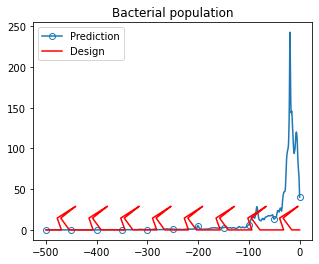

37 0.1789441965520382 loss =  202528.8125 loss_min =  194252.859375
38 0.17668906413018703 loss =  214024.28125 loss_min =  194252.859375
39 0.1900726892054081 loss =  216781.921875 loss_min =  194252.859375
40 0.17379913665354252 loss =  268171.375 loss_min =  194252.859375
41 0.17763863317668438 loss =  194151.84375 loss_min =  194252.859375
tensor([ 4.9717, -1.5362,  2.3073, -2.8715,  0.9111,  1.9244],
       grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, x4, x5, h  =  61.30792999267578 -30.65396499633789 -10.857269287109375 -14.236906051635742 -43.726051330566406 -38.156455993652344 29.464189529418945


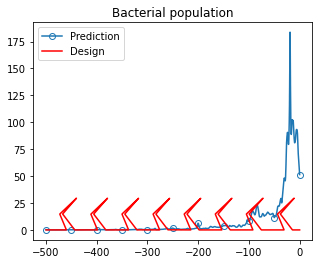

42 0.17768538370728493 loss =  190532.703125 loss_min =  194151.84375
tensor([ 5.9062, -1.6373,  1.5643, -3.8704,  0.8842,  2.0170],
       grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, x4, x5, h  =  60.51587677001953 -30.257938385009766 -9.85378646850586 -12.617764472961426 -42.827171325683594 -37.797889709472656 29.795761108398438


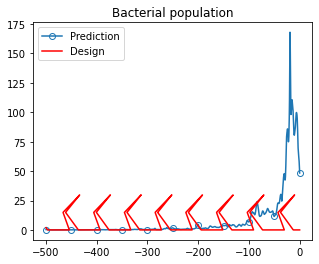

43 0.19471578672528267 loss =  212345.171875 loss_min =  190532.703125
44 0.19185787625610828 loss =  211018.078125 loss_min =  190532.703125
45 0.19349184818565845 loss =  217231.53125 loss_min =  190532.703125
46 0.1937486995011568 loss =  206203.234375 loss_min =  190532.703125
47 0.1789382379502058 loss =  215690.6875 loss_min =  190532.703125
48 0.19421082735061646 loss =  220654.65625 loss_min =  190532.703125
49 0.16748587414622307 loss =  187716.375 loss_min =  190532.703125
tensor([ 5.1219, -2.8317,  2.1848, -4.6084,  0.2912,  0.2982],
       grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, x4, x5, h  =  61.126617431640625 -30.563308715820312 -3.400787353515625 -13.989428520202637 -34.98203659057617 -20.07947540283203 29.901308059692383


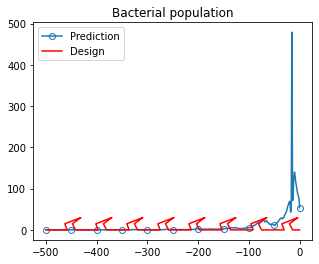

50 0.20812061429023743 loss =  425534.125 loss_min =  187716.375
51 0.1131298802793026 loss =  198151.71875 loss_min =  187716.375
52 0.18735668994486332 loss =  211761.65625 loss_min =  187716.375
53 0.17932253703474998 loss =  204868.671875 loss_min =  187716.375
54 0.18863482400774956 loss =  285279.59375 loss_min =  187716.375
55 0.1857974398881197 loss =  203759.9375 loss_min =  187716.375
56 0.18806563690304756 loss =  263402.6875 loss_min =  187716.375
57 0.17385894060134888 loss =  286287.65625 loss_min =  187716.375
58 0.1880904659628868 loss =  222577.5625 loss_min =  187716.375
59 0.17964009754359722 loss =  355263.15625 loss_min =  187716.375
60 0.18193471990525723 loss =  191088.421875 loss_min =  187716.375
61 0.1770163606852293 loss =  209327.875 loss_min =  187716.375
62 0.1801681499928236 loss =  195405.578125 loss_min =  187716.375
63 0.17860946618020535 loss =  196460.796875 loss_min =  187716.375
64 0.19285949878394604 loss =  205925.296875 loss_min =  187716.375
65

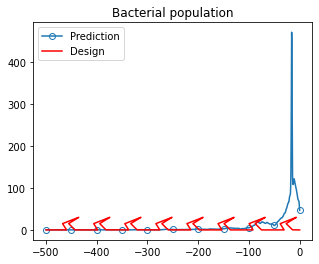

72 0.17900104448199272 loss =  231991.296875 loss_min =  186217.71875
73 0.17824552580714226 loss =  212129.78125 loss_min =  186217.71875
74 0.18114328011870384 loss =  206397.046875 loss_min =  186217.71875
75 0.1801807228475809 loss =  237099.03125 loss_min =  186217.71875
76 0.2009432315826416 loss =  226874.765625 loss_min =  186217.71875
77 0.16571580059826374 loss =  203345.671875 loss_min =  186217.71875
78 0.18531112745404243 loss =  202606.15625 loss_min =  186217.71875
79 0.18018794432282448 loss =  218451.640625 loss_min =  186217.71875
80 0.1857154630124569 loss =  235841.828125 loss_min =  186217.71875
81 0.19130157306790352 loss =  255758.875 loss_min =  186217.71875
82 0.18254942819476128 loss =  264552.34375 loss_min =  186217.71875
83 0.19437340274453163 loss =  378971.25 loss_min =  186217.71875
84 0.177331680431962 loss =  188122.515625 loss_min =  186217.71875
85 0.187906077131629 loss =  342072.59375 loss_min =  186217.71875
86 0.17594528570771217 loss =  280745.4

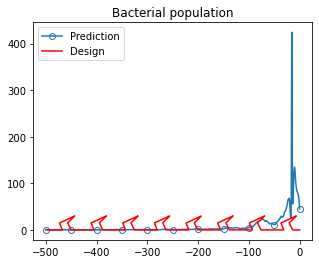

110 0.22009168565273285 loss =  369766.34375 loss_min =  183755.96875
111 0.1890850905328989 loss =  222353.484375 loss_min =  183755.96875
112 0.19906841218471527 loss =  300271.6875 loss_min =  183755.96875
113 0.19447729177773 loss =  309040.71875 loss_min =  183755.96875
114 0.18231751956045628 loss =  238547.234375 loss_min =  183755.96875
115 0.18297195248305798 loss =  206603.34375 loss_min =  183755.96875
116 0.19492749497294426 loss =  508646.40625 loss_min =  183755.96875
117 0.17128786630928516 loss =  198721.125 loss_min =  183755.96875
118 0.19569028355181217 loss =  274058.90625 loss_min =  183755.96875
119 0.20661689154803753 loss =  325962.3125 loss_min =  183755.96875
120 0.19518072344362736 loss =  252827.125 loss_min =  183755.96875
121 0.2046119924634695 loss =  355930.625 loss_min =  183755.96875
122 0.11605518124997616 loss =  195057.390625 loss_min =  183755.96875
123 0.21613403595983982 loss =  393150.1875 loss_min =  183755.96875
124 0.20681246370077133 loss = 

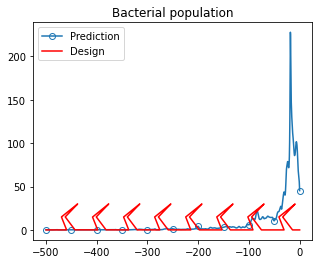

155 0.181763282045722 loss =  184381.09375 loss_min =  180671.484375
156 0.19179672561585903 loss =  228875.53125 loss_min =  180671.484375
157 0.18753042817115784 loss =  235248.90625 loss_min =  180671.484375
158 0.17854856327176094 loss =  197456.3125 loss_min =  180671.484375
159 0.18114500306546688 loss =  252555.59375 loss_min =  180671.484375
160 0.19939458556473255 loss =  378596.40625 loss_min =  180671.484375
161 0.116050124168396 loss =  196571.5 loss_min =  180671.484375
162 0.20822427235543728 loss =  421049.3125 loss_min =  180671.484375
163 0.21067330427467823 loss =  339688.46875 loss_min =  180671.484375
164 0.17797944508492947 loss =  195886.671875 loss_min =  180671.484375
165 0.17846988700330257 loss =  215180.9375 loss_min =  180671.484375
166 0.17480775713920593 loss =  184412.59375 loss_min =  180671.484375
167 0.1821013279259205 loss =  218575.40625 loss_min =  180671.484375
168 0.17771578393876553 loss =  223279.21875 loss_min =  180671.484375
169 0.18188384920

In [5]:
################################################################
# inverse optimization for 1d
################################################################


model = torch.load("catheter_plain_length_model_1d1000", map_location=device)
print(count_params(model))


epochs = 500


# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               
#               15 < x3 - x1 < L_p/2
#             -L_p < x2      < 0
#               20 < h       < 30
#             -L_p < x4  < -dx5_x4
#             dx5_x4 < x5 - x4  < 0 - x4 (dx5_x4 + x4 < x5 < 0)
# def transfer(theta):

dx5_x4 = 0

def transfer(theta):
    
    L_p = 60 + (250 - 60)/(1 + torch.exp(theta[0]))
    x1 = -0.5*L_p
    x3 = x1  + 15 + (L_p/2 - 15)/(1 + torch.exp(theta[2]))
    x2 = -L_p  + L_p/(1 + torch.exp(theta[1]))
    h = 20   + (10)/(1 + torch.exp(theta[3]))
    #
    x4 = -L_p  + (-dx5_x4 + L_p)/(1 + torch.exp(theta[4]))
    x5 = x4  + dx5_x4 + (-x4 - dx5_x4)/(1 + torch.exp(theta[5]))

    return L_p, x1, x2, x3, x4, x5, h


def inv_transfer(L_p, x2, x3, x4, x5, h):
    x1 = -0.5*L_p
    theta = np.zeros(6)

    theta[0] = np.log( (250 - 60)/(L_p - 60) - 1 )
    theta[1] = np.log( L_p/(x2 + L_p) - 1 )
    theta[2] = np.log( (L_p/2 - 15)/(x3 - x1  - 15) - 1 )
    theta[3] = np.log( 10/(h - 20 ) - 1 )
    
    theta[4] = np.log( (-dx5_x4 + L_p)/(x4 + L_p) - 1 )
    theta[5] = np.log( (-x4 - dx5_x4)/(x5 - x4  - dx5_x4) - 1 )    
    
    return theta


L_p, x2, x3, x4, x5, h = 100.0, -30.0, -30.0, -50.0, -30.0, 25.0, 

theta0 =    inv_transfer(L_p, x2, x3, x4, x5, h) 


theta = torch.tensor(theta0.astype(np.float32) , requires_grad=True)
print("initialize : ", transfer(theta))

L_x = 500
N_s = 2001
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)

max_iter = 100

optimizer = torch.optim.LBFGS([theta], max_iter=max_iter, lr=1.0, line_search_fn="strong_wolfe")

loss_min = torch.tensor(np.inf)
theta_min = torch.clone(theta)

for ep in range(epochs):
    t1 = default_timer()
    def loss_closure():
        
        L_p, x1, x2, x3, x4, x5, h = transfer(theta)
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, x4, x5, h, N_s)
    
        optimizer.zero_grad()
        out = torch.exp(model(x).squeeze())
        loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
        loss.backward()
        
        return loss
    
    
    optimizer.step(loss_closure)

    t2 = default_timer()
 
    if ep%1==0:
        
        L_p, x1, x2, x3, x4, x5, h = transfer(theta)
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, x4, x5, h, N_s)
    
        out = torch.exp(model(x).squeeze())
        loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
        print(ep, t2 - t1,  "loss = ", loss.item(), "loss_min = ", loss_min.item(),)
        
        
        if loss < loss_min:
            
            theta_min = torch.clone(theta)
            loss_min = loss
            print(theta_min)
            mesh = x.detach().cpu().numpy()
            print("L_p, x1, x2, x3, x4, x5, h  = ", L_p.item(), x1.item(), x2.item(), x3.item(), x4.item(), x5.item(), h.item())


            plt.figure(figsize=(5,4))
            plt.title("Bacterial population")
            plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "-o", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
            plt.plot(mesh[0, :, 0], mesh[0, :, 1], color="r", label="Design")

            plt.legend()
            plt.show()
            
        theta = theta_min + torch.normal(mean=0.0, std=torch.ones(len(theta)))
        
        
        
        
# for ep in range(epochs):
#     model.train()
#     t1 = default_timer()
    
#     L_p, x1, x2, x3, x4, x5, h = transfer(theta)
#     x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, x4, x5, h, N_s)
    
#     out = torch.clip(model(x).squeeze(), min=0.0)
#     # maximize negative mean
#     loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
    
#     loss.backward()
#     optimizer.step()
#     scheduler.step()

#     t2 = default_timer()
    
#     if ep%200==0:
#         print(ep, t2 - t1,  "loss = ", loss.item())

#         mesh = x.detach().cpu().numpy()
#         print("L_p, x1, x2, x3, x4, x5, h  = ", L_p.item(), x1.item(), x2.item(), x3.item(), x4.item(), x5.item(), h.item())
#         plt.figure(figsize=(5,4))
#         plt.title("Bacterial population")
#         plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "-o", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
#         plt.plot(mesh[0, :, 0], mesh[0, :, 1], color="r", label="Design")
        
#         plt.legend()
#         plt.show()
# #         plt.savefig("Catheter."+str(ep).zfill(5)+".pdf")

1336001
initialize :  (tensor(100., grad_fn=<AddBackward0>), tensor(-50., grad_fn=<MulBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(-50., grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(25., grad_fn=<AddBackward0>))
0 0.570810105651617 loss =  216779.90625 loss_min =  inf
tensor([ 3.4537, -2.6653,  1.6620, -0.0729,  1.3024,  2.6572],
       grad_fn=<CloneBackward0>)
L_p, x1, x2, x3, x4, x5, h  =  65.82542419433594 -32.91271209716797 -4.282047271728516 -15.055727005004883 -54.96080017089844 -37.341556549072266 25.18229103088379


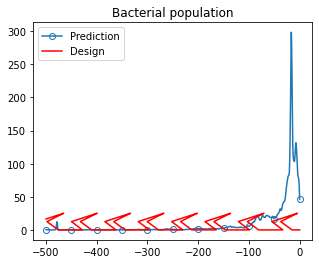

1 0.2167672999203205 loss =  216779.90625 loss_min =  216779.90625
2 0.2156338430941105 loss =  216779.90625 loss_min =  216779.90625
3 0.22127677127718925 loss =  216779.90625 loss_min =  216779.90625
4 0.22965208068490028 loss =  216779.90625 loss_min =  216779.90625
5 0.2188777569681406 loss =  216779.90625 loss_min =  216779.90625
6 0.23187016136944294 loss =  216779.90625 loss_min =  216779.90625
7 0.22206119261682034 loss =  216779.90625 loss_min =  216779.90625
8 0.22364316321909428 loss =  216779.90625 loss_min =  216779.90625
9 0.22108246013522148 loss =  216779.90625 loss_min =  216779.90625
10 0.22314240224659443 loss =  216779.90625 loss_min =  216779.90625
11 0.1993358712643385 loss =  216779.90625 loss_min =  216779.90625
12 0.22502029314637184 loss =  216779.90625 loss_min =  216779.90625
13 0.2217384185642004 loss =  216779.90625 loss_min =  216779.90625
14 0.21874305978417397 loss =  216779.90625 loss_min =  216779.90625
15 0.21988406591117382 loss =  216779.90625 loss

In [10]:
################################################################
# inverse optimization for 1d
################################################################


model = torch.load("catheter_plain_length_model_1d1000", map_location=device)
print(count_params(model))


epochs = 500


# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               
#               15 < x3 - x1 < L_p/2
#             -L_p < x2      < 0
#               20 < h       < 30
#             -L_p < x4  < -dx5_x4
#             dx5_x4 < x5 - x4  < 0 - x4 (dx5_x4 + x4 < x5 < 0)
# def transfer(theta):

dx5_x4 = 15

def transfer(theta):
    
    L_p = 60 + (250 - 60)/(1 + torch.exp(theta[0]))
    x1 = -0.5*L_p
    x3 = x1  + 15 + (L_p/2 - 15)/(1 + torch.exp(theta[2]))
    x2 = -L_p  + L_p/(1 + torch.exp(theta[1]))
    h = 20   + (10)/(1 + torch.exp(theta[3]))
    #
    x4 = -L_p  + (-dx5_x4 + L_p)/(1 + torch.exp(theta[4]))
    x5 = x4  + dx5_x4 + (-x4 - dx5_x4)/(1 + torch.exp(theta[5]))

    return L_p, x1, x2, x3, x4, x5, h


def inv_transfer(L_p, x2, x3, x4, x5, h):
    x1 = -0.5*L_p
    theta = np.zeros(6)

    theta[0] = np.log( (250 - 60)/(L_p - 60) - 1 )
    theta[1] = np.log( L_p/(x2 + L_p) - 1 )
    theta[2] = np.log( (L_p/2 - 15)/(x3 - x1  - 15) - 1 )
    theta[3] = np.log( 10/(h - 20 ) - 1 )
    
    theta[4] = np.log( (-dx5_x4 + L_p)/(x4 + L_p) - 1 )
    theta[5] = np.log( (-x4 - dx5_x4)/(x5 - x4  - dx5_x4) - 1 )    
    
    return theta


L_p, x2, x3, x4, x5, h = 100.0, -30.0, -30.0, -50.0, -30.0, 25.0, 

theta0 =    inv_transfer(L_p, x2, x3, x4, x5, h) 


theta = torch.tensor(theta0.astype(np.float32) , requires_grad=True)
print("initialize : ", transfer(theta))

L_x = 500
N_s = 2001
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)

max_iter = 100

optimizer = torch.optim.LBFGS([theta], max_iter=max_iter, lr=1.0, line_search_fn="strong_wolfe")

loss_min = torch.tensor(np.inf)
theta_min = torch.clone(theta)

for ep in range(epochs):
    t1 = default_timer()
    def loss_closure():
        
        L_p, x1, x2, x3, x4, x5, h = transfer(theta)
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, x4, x5, h, N_s)
    
        optimizer.zero_grad()
        out = torch.exp(model(x).squeeze())
        loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
        loss.backward()
        
        return loss
    
    
    optimizer.step(loss_closure)

    t2 = default_timer()
 
    if ep%1==0:
        
        L_p, x1, x2, x3, x4, x5, h = transfer(theta)
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, x4, x5, h, N_s)
    
        torch.exp(model(x).squeeze())
        loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
        print(ep, t2 - t1,  "loss = ", loss.item(), "loss_min = ", loss_min.item(),)
        
        
        if loss < loss_min:
            
            theta_min = torch.clone(theta)
            loss_min = loss
            print(theta_min)
            mesh = x.detach().cpu().numpy()
            print("L_p, x1, x2, x3, x4, x5, h  = ", L_p.item(), x1.item(), x2.item(), x3.item(), x4.item(), x5.item(), h.item())


            plt.figure(figsize=(5,4))
            plt.title("Bacterial population")
            plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "-o", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
            plt.plot(mesh[0, :, 0], mesh[0, :, 1], color="r", label="Design")

            plt.legend()
            plt.show()
            
        theta = theta_min + torch.normal(mean=0.0, std=torch.ones(len(theta)))
        
        
        
        
